In [1]:
import collections
import json
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import tensorflow as tf
import time
import pandas as pd

from gensim.parsing.preprocessing import remove_stopwords
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu,SmoothingFunction
from tqdm import tqdm
from PIL import Image

## Loading and Downloading

In [2]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

# Download train captions file
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                           extract=False)

# Download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                           extract=False)

40960/29242 [==========================================] - 0s 0us/step


#### Create directories for InceptionV3 and Xception

In [3]:
mkdir iv3

In [4]:
mkdir xce

In [5]:
train_df = pd.read_csv(train_captions_file, on_bad_lines='skip', names=['caption'])
test_df = pd.read_csv(test_images_file, names=['tests'])

In [6]:
train2_df = train_df
train_df[['image', 'index', 'caption']] = train2_df['caption'].str.split('|', expand=True)

In [7]:
PATH = '/kaggle/working/image_dir/'

In [8]:
train_df['caption'] = '<start>' + train_df['caption'] + ' <end>'
train_df['image'] = PATH + train_df['image']

In [9]:
img_name_vector = train_df['image']
train_captions = train_df['caption']

<start> A little girl holds orange lilies while others celebrate an occasion in a garden setting . <end>


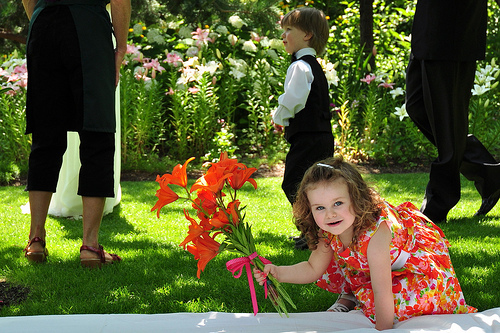

In [10]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Word embedding model

In [11]:
WORD_2_VEC = 50 # Other options {100, 200, 300}
vocabulary_size = 250000 # Normally is 400000, but there is not enough storage
model_50 = gensim.downloader.load("glove-wiki-gigaword-50")
word_2_vec = model_50

[==================================================] 100.0% 66.0/66.0MB downloaded


## Preprocessing Captions

In [12]:
def standardize_pre(inputs):
    inputs = inputs.lower()
    inputs = re.sub(r"[!\"$%&\(\)<>\*\+.,-/:;=?@\[\\\]^_`{|}~]", "", inputs)
    return ' '.join(inputs.split())

In [13]:
train_captions_preprocessed = [standardize_pre(cap) for cap in train_captions]

Max: 74 | Min: 2


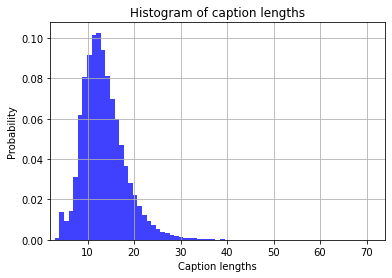

In [14]:
caption_lengths = [len(cap.split(" ")) for cap in train_captions_preprocessed]
print(f"Max: {max(caption_lengths)} | Min: {min(caption_lengths)}")
bins = max(caption_lengths) - min(caption_lengths) + 1

plt.hist(caption_lengths, bins, density=True, facecolor='b', alpha=0.75)
plt.xlabel('Caption lengths')
plt.ylabel('Probability')
plt.title('Histogram of caption lengths')
plt.xlim(min(caption_lengths), max(caption_lengths))
plt.grid(True)
plt.show()

Looks like the length of most captions is from 6 to 20

In [15]:
min_length = 6
max_length = 20

In [16]:
train_captions_final = []
img_name_vector_final = []
for cap, img in zip(train_captions_preprocessed, img_name_vector):
    len_ = len(cap.split(" "))
    if len_ < min_length or len_ > max_length:
        continue
    else:
        train_captions_final.append(cap + " .") 
        img_name_vector_final.append(img)
img_name_vector = img_name_vector_final

In [17]:
# Add $ padding. Won't be taken into account at the evaluation
def pad(cap, length):
    _len = len(cap.split(" "))
    pad_size = max_length - _len + 1
    cap = cap + " $" * pad_size
    return cap

train_captions_final = [pad(cap, max_length+1) for cap in train_captions_final]    

In [18]:
cap_vector = tf.data.Dataset.from_tensor_slices(train_captions_final)

2022-03-09 16:09:08.296683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 16:09:08.387638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 16:09:08.388389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 16:09:08.394393: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

start a woman shakes hand with another woman end . $ $ $ $ $ $ $ $ $ $ $


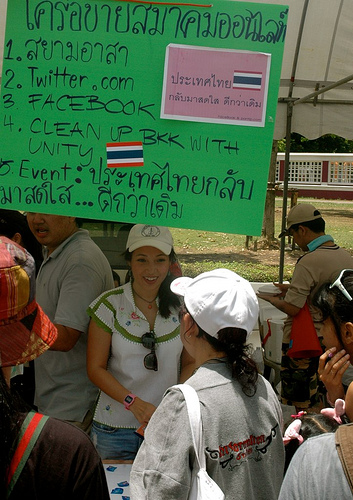

In [19]:
print(list(cap_vector.as_numpy_iterator())[13].decode('utf-8'))
Image.open(img_name_vector[13])

## Create Image Vectors

### InceptionV3 Encoder

The encoder takes a 3-channel input image of size 299x299

In [20]:
def load_image_inceptionv3(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [21]:
img_model_inceptionv3 = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = img_model_inceptionv3.input
hidden_layer = img_model_inceptionv3.layers[-1].output

encoder_inceptionv3 = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [22]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image_inceptionv3, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = encoder_inceptionv3(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        path_of_feature = path_of_feature.split("/")[-1]
        path_of_feature = f"./iv3/{path_of_feature}"
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/1862 [00:00<?, ?it/s]2022-03-09 16:09:21.582333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-09 16:09:22.445252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 1862/1862 [05:08<00:00,  6.04it/s]


In [23]:
for i, p in image_dataset:
    print(f"Initial shape: {i.shape}")
    a = encoder_inceptionv3(i)
    print(f"After encoder shape: {a.shape}")
    a = tf.reshape(a,(a.shape[0], -1, a.shape[3]))
    print(f"After reshape shape: {a.shape}")
    break

Initial shape: (16, 299, 299, 3)
After encoder shape: (16, 8, 8, 2048)
After reshape shape: (16, 64, 2048)


In [24]:
img_sample_vector=np.load('iv3/_1000070808.jpg.npy')
print(f"Saved shape: {img_sample_vector.shape}")
print(img_sample_vector)

Saved shape: (64, 2048)
[[0.         0.         1.5340885  ... 0.         0.12995026 0.        ]
 [0.         0.5207992  0.9947564  ... 0.         0.32282615 0.        ]
 [0.00333762 0.01375987 0.11753933 ... 0.0249117  0.43025413 0.        ]
 ...
 [2.7146544  0.         2.1412072  ... 1.934655   0.         0.        ]
 [0.55238706 0.         0.16969155 ... 2.1330912  0.         0.        ]
 [0.2377345  0.         0.         ... 2.0439234  0.         0.33832744]]


### Xception Encoder

This encoder takes a 3-channel image of size 299x299 as input. Kaggle has a problem with the input size being 299, therefore we downscaled the images to 224. 
*Note*: The resizing problem does not occur in InceptionV3 for obvious reasons.

In [25]:
# def load_image_xception(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.keras.layers.Resizing(224, 224)(img) #299
#     img = tf.keras.applications.xception.preprocess_input(img)
#     return img, image_path

In [26]:
# img_model_xception = tf.keras.applications.Xception(include_top=False,
#                                                 weights='imagenet')
# new_input = img_model_xception.input
# hidden_layer = img_model_xception.layers[-1].output

# encoder_xception = tf.keras.Model(new_input, hidden_layer)

In [27]:
# encode_train = sorted(set(img_name_vector))

# image_dataset_xception = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset_xception = image_dataset_xception.map(
#   load_image_xception, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# for img, path in tqdm(image_dataset_xception):
#     batch_features = encoder_xception(img)
#     batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         path_of_feature = path_of_feature.split("/")[-1]
#         path_of_feature = f"./xce/{path_of_feature}"
#         np.save(path_of_feature, bf.numpy())

In [28]:
# for i, p in image_dataset_xception:
#     print(f"Initial shape: {i.shape}")
#     a = encoder_xception(i)
#     print(f"After encoder shape: {a.shape}")
#     a = tf.reshape(a,(a.shape[0], -1, a.shape[3]))
#     print(f"After reshape shape: {a.shape}")
#     break

In [29]:
# img_sample_vector=np.load('xce/_1000070808.jpg.npy')
# print(f"Saved shape: {img_sample_vector.shape}")
# print(img_sample_vector)

## Split the data into training and validating

In [30]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [31]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(108323, 108323, 27002, 27002)

## Create a tf.data dataset for training (InceptionV3)

In [32]:
BATCH_SIZE = 64 # Το πληθος των inputs που δινουμε στο μοντέλο κάθε φορά
BUFFER_SIZE = 1000 # Ειναι για το shuffling μονο
embedding_dim = WORD_2_VEC # Αντιστοιχεί στο μήκος του embedding που θέλουμε να χρησιμοποιήσουμε
units = 512 # GRUS
num_steps = len(img_name_train) // BATCH_SIZE #Ειναι για το training και τον υπολογισμό του loss
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [33]:
# Load the numpy files for iv3 & create vectors
def map_func_iv3(img_name, cap):
    capl = []
    indexl = []
    for w in str(cap).split(" "):
        # Get the embeddings and indexes
        try:
            capl.append(word_2_vec.get_vector(w))
            indexl.append(word_2_vec.key_to_index[w])
            if indexl[-1] >= vocabulary_size:
                # Εκτός vocabulary_size τα κάνω $ ώστε να τα παραλείπω αργότερα στο loss_function (αντίστοιχα UNK)
                indexl[-1] = word_2_vec.key_to_index["$"]
        except KeyError:
            # Το αντικαθιστώ τα KeyErrors με $ ώστε να τα παραλείπω αργότερα στο loss_function
            capl.append(word_2_vec.get_vector("$"))
            indexl.append(word_2_vec.key_to_index["$"])
    path_of_feature = img_name.decode('utf-8').split("/")[-1]
    img_tensor = np.load("iv3/"+path_of_feature+'.npy')
    return img_tensor, tf.convert_to_tensor(capl, dtype=tf.float32), tf.convert_to_tensor(indexl, dtype=tf.int32)

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func_iv3, [item1, item2], [tf.float32, tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
for i in dataset:
    print(i[0].shape) # (BATCH_SIZE, attention_features_shape, features_shape)
    print(i[1].shape) # (BATCH_SIZE, caption_max_size, embedding_dim)
    print(i[2].shape) # (BATCH_SIZE, caption_max_size)
    break

(64, 64, 2048)
(64, 21, 50)
(64, 21)


2022-03-09 16:14:42.704949: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.


## Create a tf.data dataset for training (Xception)



In [36]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = WORD_2_VEC
# units = 512 # GRUS
# num_steps = len(img_name_train) // BATCH_SIZE
# features_shape = 2048
# attention_features_shape = 49

In [37]:
# # Load the numpy files for xception
# def map_func_xce(img_name, cap):
#     capl = []
#     indexl = []
#     for w in str(cap).split(" "):
#         # Get the embeddings and indexes
#         try:
#             capl.append(word_2_vec.get_vector(w))
#             indexl.append(word_2_vec.key_to_index[w])
#             if indexl[-1] >= vocabulary_size:
#                 # Out of the vocab size bounds I turn them to $ so I can omit them at the loss function
#                 indexl[-1] = word_2_vec.key_to_index["$"]
#         except KeyError:
#             # I turn KeyErrors to $ so I can omit them at the loss function
#             capl.append(word_2_vec.get_vector("$"))
#             indexl.append(word_2_vec.key_to_index["$"])
#     path_of_feature = img_name.decode('utf-8').split("/")[-1]
#     img_tensor = np.load("xce/"+path_of_feature+'.npy')
#     return img_tensor, tf.convert_to_tensor(capl, dtype=tf.float32), tf.convert_to_tensor(indexl, dtype=tf.int32)

In [38]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# # Use map to load the numpy files in parallel
# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func_xce, [item1, item2], [tf.float32, tf.float32, tf.int32]),
#           num_parallel_calls=tf.data.AUTOTUNE)

# # Shuffle and batch
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
# for i in dataset:
#     print(i[0].shape)
#     print(i[1].shape)
#     print(i[2].shape)
#     break

## Model

In [40]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [41]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [42]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, GRU = True):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.GRU = GRU
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        if self.GRU:
            self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        else:
            self.gru = tf.keras.layers.LSTM(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.drp = tf.keras.layers.Dropout(0.4)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        if self.GRU:
            output, state = self.gru(x)
        else:
            output, sate, carry_state = self.gru(x)

        x = self.fc1(output)
        x = self.drp(x, training=True)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocabulary_size)

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    # We ignore the $ (=padding & words that don't belong to our vocabulary)
    mask = tf.math.logical_not(tf.math.equal(real, word_2_vec.key_to_index["$"]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Regularization

We added a 0.4 rate Dropout in our RNN model, which somewhat improved its accuracy.

## Decoder

LSTM has a lower accuracy than the GRU, so we kept the GRU. LSTM is viable as well, since the difference in the bleu_score is not very big compared to the GRU's.

## Checkpoint

In [45]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [46]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [47]:
# adding this in a separate cell in order not to reset the loss plot array
loss_plot = []

In [48]:
@tf.function
def train_step(img_tensor, target, target_indexes):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tf.convert_to_tensor(word_2_vec.get_vector("#"))] * target.shape[0],1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target_indexes[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [49]:
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target, target_indexes)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, target_indexes)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

2022-03-09 16:14:44.936198: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2022-03-09 16:14:45.479787: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.


Epoch 1 Batch 0 Loss 7.3802


2022-03-09 16:15:08.991628: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2022-03-09 16:15:09.529673: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.


Epoch 1 Batch 100 Loss 3.2088
Epoch 1 Batch 200 Loss 2.8320
Epoch 1 Batch 300 Loss 2.6508
Epoch 1 Batch 400 Loss 2.5759
Epoch 1 Batch 500 Loss 2.3685
Epoch 1 Batch 600 Loss 2.2084
Epoch 1 Batch 700 Loss 2.3276
Epoch 1 Batch 800 Loss 2.0194
Epoch 1 Batch 900 Loss 2.2744
Epoch 1 Batch 1000 Loss 2.2789
Epoch 1 Batch 1100 Loss 2.2642
Epoch 1 Batch 1200 Loss 1.9308
Epoch 1 Batch 1300 Loss 2.2000
Epoch 1 Batch 1400 Loss 2.0770
Epoch 1 Batch 1500 Loss 2.0637
Epoch 1 Batch 1600 Loss 2.1400
Epoch 1 Loss 2.380330
Time taken for 1 epoch 946.19 sec

Epoch 2 Batch 0 Loss 1.7991
Epoch 2 Batch 100 Loss 2.1842
Epoch 2 Batch 200 Loss 2.0430
Epoch 2 Batch 300 Loss 1.8321
Epoch 2 Batch 400 Loss 2.2601
Epoch 2 Batch 500 Loss 2.1489
Epoch 2 Batch 600 Loss 2.0203
Epoch 2 Batch 700 Loss 1.8565
Epoch 2 Batch 800 Loss 1.9179
Epoch 2 Batch 900 Loss 2.0123
Epoch 2 Batch 1000 Loss 1.9154
Epoch 2 Batch 1100 Loss 1.8451
Epoch 2 Batch 1200 Loss 1.8328
Epoch 2 Batch 1300 Loss 2.0648
Epoch 2 Batch 1400 Loss 1.8990
Epo

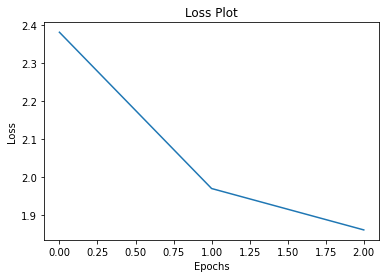

In [50]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

As we see, the model converges due to the loss being gradually smaller.

## Sentence Generator

The literature reports that the Beam Search method produces significantly better results. Beam Search has a hyperparameter which is the width of the beam b. To pick the next word it starts from the beginning of the sentence and keeps the b best (most likely) words for the next step. This way b branches are created. For the next step it calculates the probabilities of the next words for all branches and keeps the b most probable and so on. In the end we end up with b possible sentences and choose the one with the best probabilities overall. For the latter, we could use for example the sum of the log of the probabilities divided by the length of each sentence.

In [51]:
def evaluate(image, gen_type=0):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_inceptionv3(image)[0], 0)
#     temp_input = tf.expand_dims(load_image_xception(image)[0], 0)
    img_tensor_val = encoder_inceptionv3(temp_input)
#     img_tensor_val = encoder_xception(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.convert_to_tensor(word_2_vec.get_vector("#"))],0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        if gen_type == 0:
            # use tf.random.categorical
            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        elif gen_type == 1:
            # use greedy search
            predicted_id = tf.math.argmax(predictions, axis=1)[0].numpy()

        predicted_word = tf.compat.as_text(word_2_vec.index_to_key[predicted_id])

        result.append(predicted_word)

        if predicted_word == '.':
            return result, attention_plot

        dec_input = tf.expand_dims([word_2_vec.get_vector(predicted_word)], 0)

    attention_plot = attention_plot[:len(result), :]
    
    # Βάλε τελεία στο τέλος αν δεν υπάρχει
    if result[-1] != '.':
        result.append('.')
    
    return result, attention_plot

In [52]:
def evaluate_beam(image, k=2):
    temp_input = tf.expand_dims(load_image_inceptionv3(image)[0], 0)
    img_tensor_val = encoder_inceptionv3(temp_input)
#     temp_input = tf.expand_dims(load_image_xception(image)[0], 0)
#     img_tensor_val = encoder_xception(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.convert_to_tensor(word_2_vec.get_vector("#"))],0)
    hidden = decoder.reset_state(batch_size=1)
    result = []
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    candidates = [(dec_input, hidden, result, attention_plot, [])]
    final_candidates = []
    for i in range(max_length):
        new_candidates = []
        for dec_input, hidden, result, attention_plot, probs in candidates:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            predicted_ids = [id_ for id_ in tf.math.top_k(predictions, k).indices[0].numpy()]
            predicted_probs = [id_ for id_ in tf.math.top_k(predictions, k).values[0].numpy()]
            predicted_words = [tf.compat.as_text(word_2_vec.index_to_key[id_]) for id_ in predicted_ids]
            #print(f"predicted_words: {predicted_words}, predicted_probs: {predicted_probs}")

            for w, prob in zip(predicted_words, predicted_probs):
                new_result = result.copy()
                new_result.append(w)
                
                new_probs = probs.copy()
                new_probs.append(prob)
        
                attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
                dec_input = tf.expand_dims([word_2_vec.get_vector(w)], 0)
                
                new_candidates.append((dec_input, hidden, new_result, attention_plot, new_probs))

        # Keep the k best
        sorted_candidates = sorted(new_candidates, key=lambda x: np.prod(x[4]), reverse=True)
        candidates = sorted_candidates[:k]
        """print("Candidates")
        for n in candidates:
            print(n[2], n[4])"""
        
        # Stop when 2 captions that end with '.' are found
        # Add final candidates to final_candidates
        for c in candidates:
            if c[2][-1] == '.':
                final_candidates.append((c[2], c[3], c[4]))
            # Stop if k final_candidates found
            if len(final_candidates) == k:
                break
        # Stop if k final_candidates found
        if len(final_candidates) == k:
            break
            
        # Remove final candidates from candidates
        candidates = [c for c in candidates if c[2][-1] != '.']
    
    # If no captions that end in '.' are found, use the k-end ones
    if len(final_candidates) < k:
        temp_candidates = [(c[2], c[3], c[4]) for c in candidates]
        final_candidates = final_candidates + temp_candidates[:k-len(final_candidates)]
    
    final_scored_candidates = []
    for result, attention_plot, probs in final_candidates:
        sum_ = 0
        for prob in probs:
            sum_ = sum_ + np.log(prob)
        score = sum_ / len(result)
        final_scored_candidates.append((result, attention_plot, score))
        
    winner = sorted(final_scored_candidates, key=lambda x: x[2], reverse=True)[0]
    result = winner[0].copy()
    final_plot = winner[1][:len(winner[0]), :]
    
    # Append '.' if it does not exist
    if result[-1] != '.':
        result.append('.')
    
    return result, final_plot

In [53]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(50, 50))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Caption Evaluation

If we assume that each image has some real captions (references) and the neural net generates its own caption (hypothesis), we will use the BLEU (Bilingual Evaluation Understudy) score, between hypothesis and references. Briefly, BLEU is a weighted average of the number of common unigrams, bigrams, trigrams, and fourgrams between hypothesis and references. The worst captioning receives 0 and the best 1. 

To be able to evaluate the captioning of an individual example we are using sentence_bleu.
To evaluate the captioning of more images e.g. the whole validation set we are using corpus_bleu. Note that corpus_bleu is not an average of sentence_bleu.
In all cases we use the following parameters: weights=(0.4, 0.3, 0.2, 0.1) and smoothing_function = SmoothingFunction().method1.

In [54]:
def get_val_blue(limit=1000, gen_type="CATEGORICAL", k=2):
    weights=(0.4, 0.3, 0.2, 0.1)
    smoothing_function=SmoothingFunction().method1

    img_2_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_val, cap_val):
        img_2_cap_vector[img].append(cap)

    total_refs = []
    toal_hyps = []

    for img in list(img_2_cap_vector.items())[:limit]:
        # Get all references
        refl = []
        for ref in img[1]:
            ref = tf.compat.as_text(ref.numpy())
            ref = ref.split(".")[0]
            ref = ref.split(" ")[1:-1]
            refl.append(ref)
        
        if gen_type == "CATEGORICAL":
            hyp, _ = evaluate(img[0])
        elif gen_type == "GREEDY":
            hyp, _ = evaluate(img[0], 1)
        else:
            hyp, _ = evaluate_beam(img[0], k)
        hyp = hyp[:-1]

        total_refs.append(refl)
        toal_hyps.append(hyp)

    return corpus_bleu(total_refs, toal_hyps, weights=weights, smoothing_function=smoothing_function)

In [55]:
score = get_val_blue(1000, gen_type="CATEGORICAL")
print("Bleu score %:",score*100)

Bleu score %: 9.396149214611036


In [56]:
score = get_val_blue(1000, gen_type="GREEDY")
print("Bleu score %:",score*100)

Bleu score %: 22.57238768087432


In [57]:
score = get_val_blue(1000, gen_type="ΒΕΑΜ", k=2)
print("Bleu score %:",score*100)

Bleu score %: 23.95288397692426


In [58]:
def get_image_blue(id, gen_type="CATEGORICAL", k=2):
    weights=(0.4, 0.3, 0.2, 0.1)
    smoothing_function=SmoothingFunction().method1
    
    img_2_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_val, cap_val):
        img_2_cap_vector[img].append(cap)
        
    img = list(img_2_cap_vector.items())[id]
    refl = []
    
    for ref in img[1]:
        ref = tf.compat.as_text(ref.numpy())
        ref = ref.split(".")[0]
        ref = ref.split(" ")[1:-1]
        refl.append(ref)

    if gen_type == "CATEGORICAL":
        hyp, _ = evaluate(img[0])
    elif gen_type == "GREEDY":
        hyp, _ = evaluate(img[0], 1)
    else:
        hyp, _ = evaluate_beam(img[0], k)
    hyp = hyp[:-1]

    return sentence_bleu(refl, hyp, weights=weights, smoothing_function=smoothing_function)

In [59]:
sentence_score = get_image_blue(1000, gen_type="CATEGORICAL")
print("Bleu score %:",sentence_score*100)

Bleu score %: 5.028639819410149


In [60]:
sentence_score = get_image_blue(1000, gen_type="GREEDY")
print("Bleu score %:",sentence_score*100)

Bleu score %: 14.57862350827342


In [61]:
sentence_score = get_image_blue(1000, gen_type="BEAM", k=2)
print("Bleu score %:",sentence_score*100)

Bleu score %: 12.224178643335039


Real Caption: start the football player in red kicks off the ball end . $ $ $ $ $ $ $ $ $
Prediction Greedy Caption: a football player in a red uniform is trying to hit a game end .


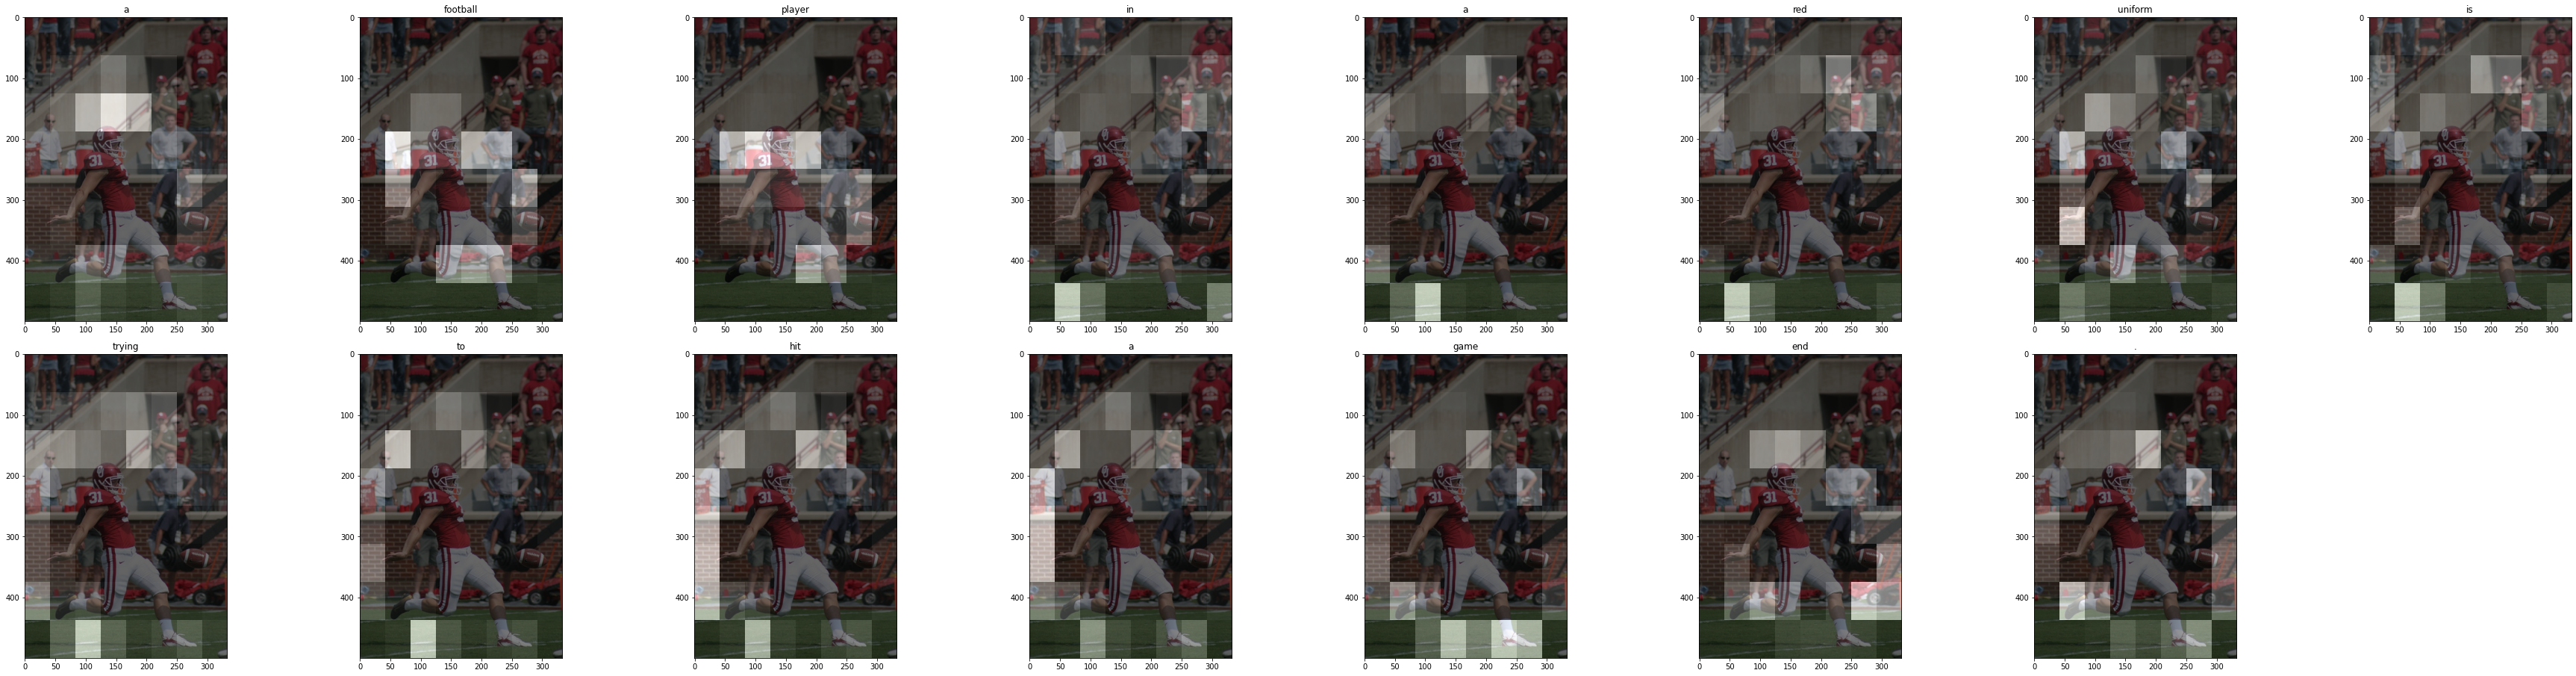

Prediction Beam Caption: a football player in a red uniform is about to score end .


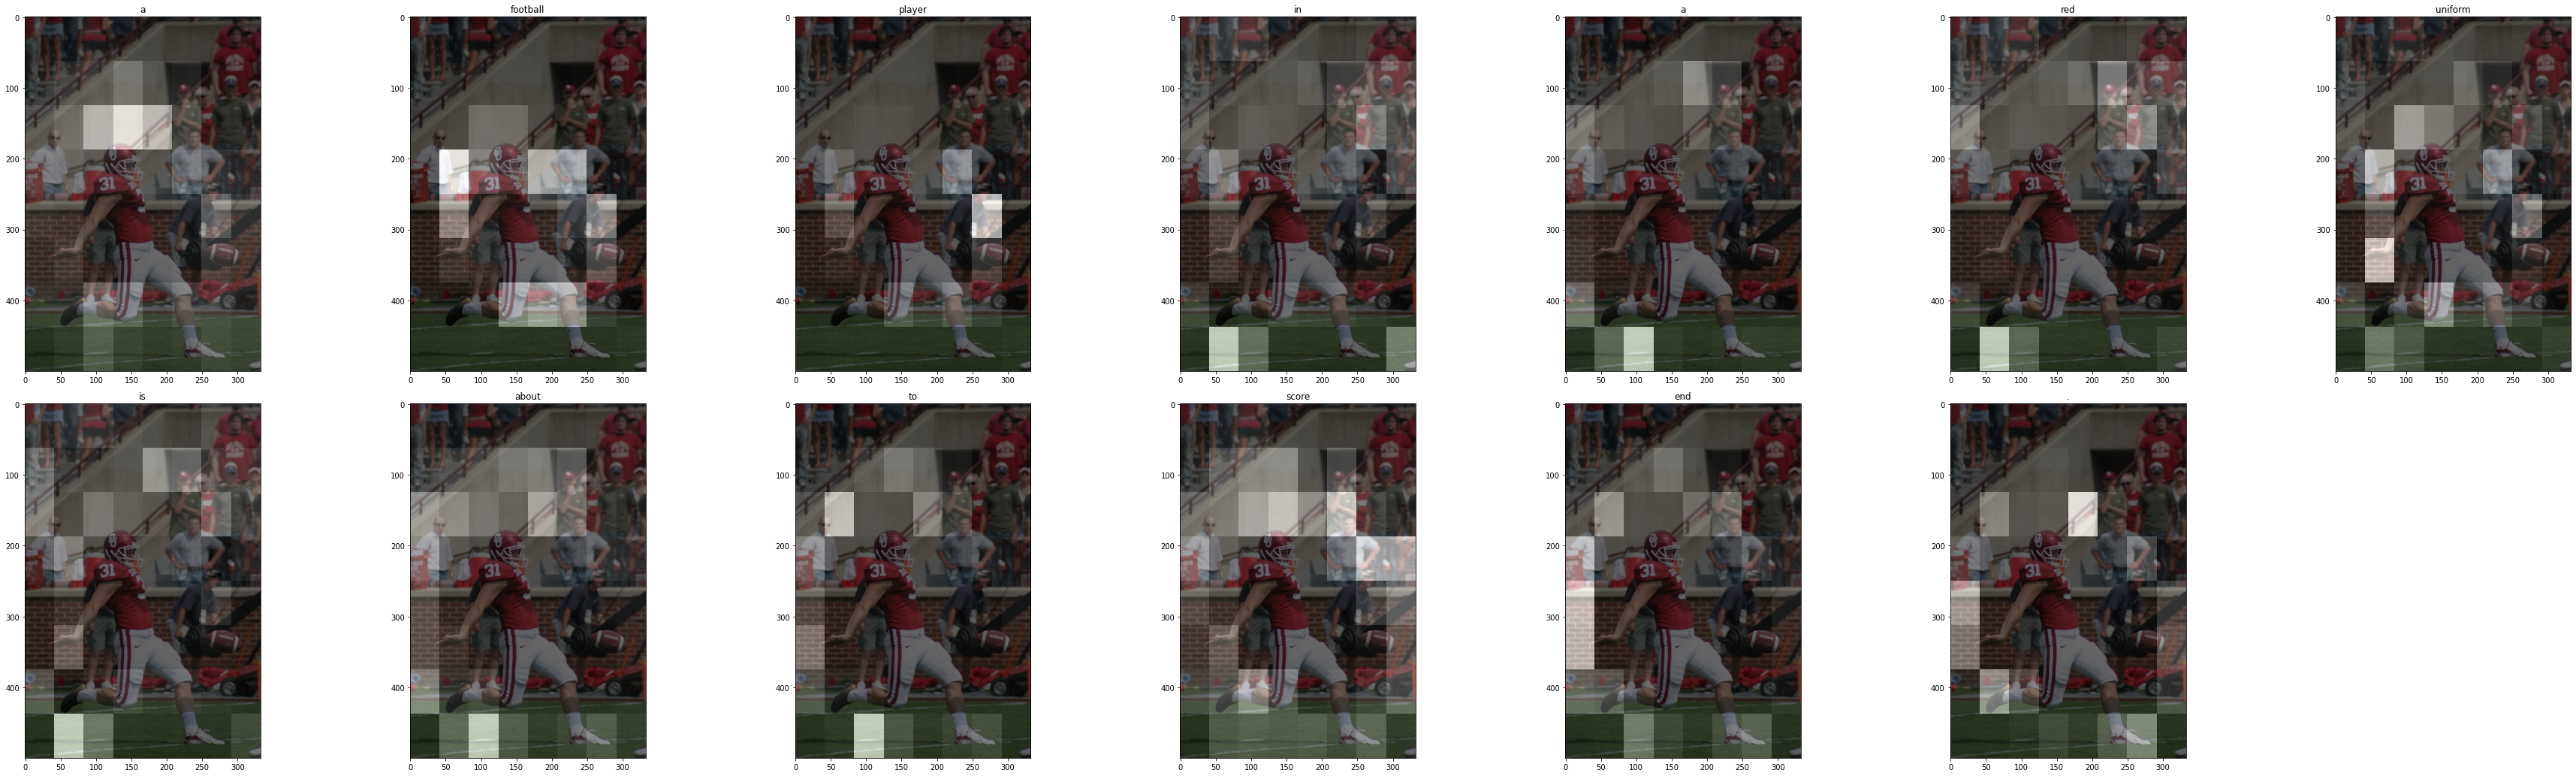

In [62]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = tf.compat.as_text(cap_val[rid].numpy())
result, attention_plot = evaluate(image)
result_greedy, attention_plot_greedy = evaluate(image, 1)
result_beam, attention_plot_beam = evaluate_beam(image, 2)

print('Real Caption:', real_caption)
print('Prediction Greedy Caption:', ' '.join(result_greedy))
plot_attention(image, result_greedy, attention_plot_greedy)
print('Prediction Beam Caption:', ' '.join(result_beam))
plot_attention(image, result_beam, attention_plot_beam)

## Try on random image

Below we are testing with a random image, outside of the dataset.


73728/64400 [==================================] - 0s 4us/step
Prediction Caption: a surfer jumps in the snow end .


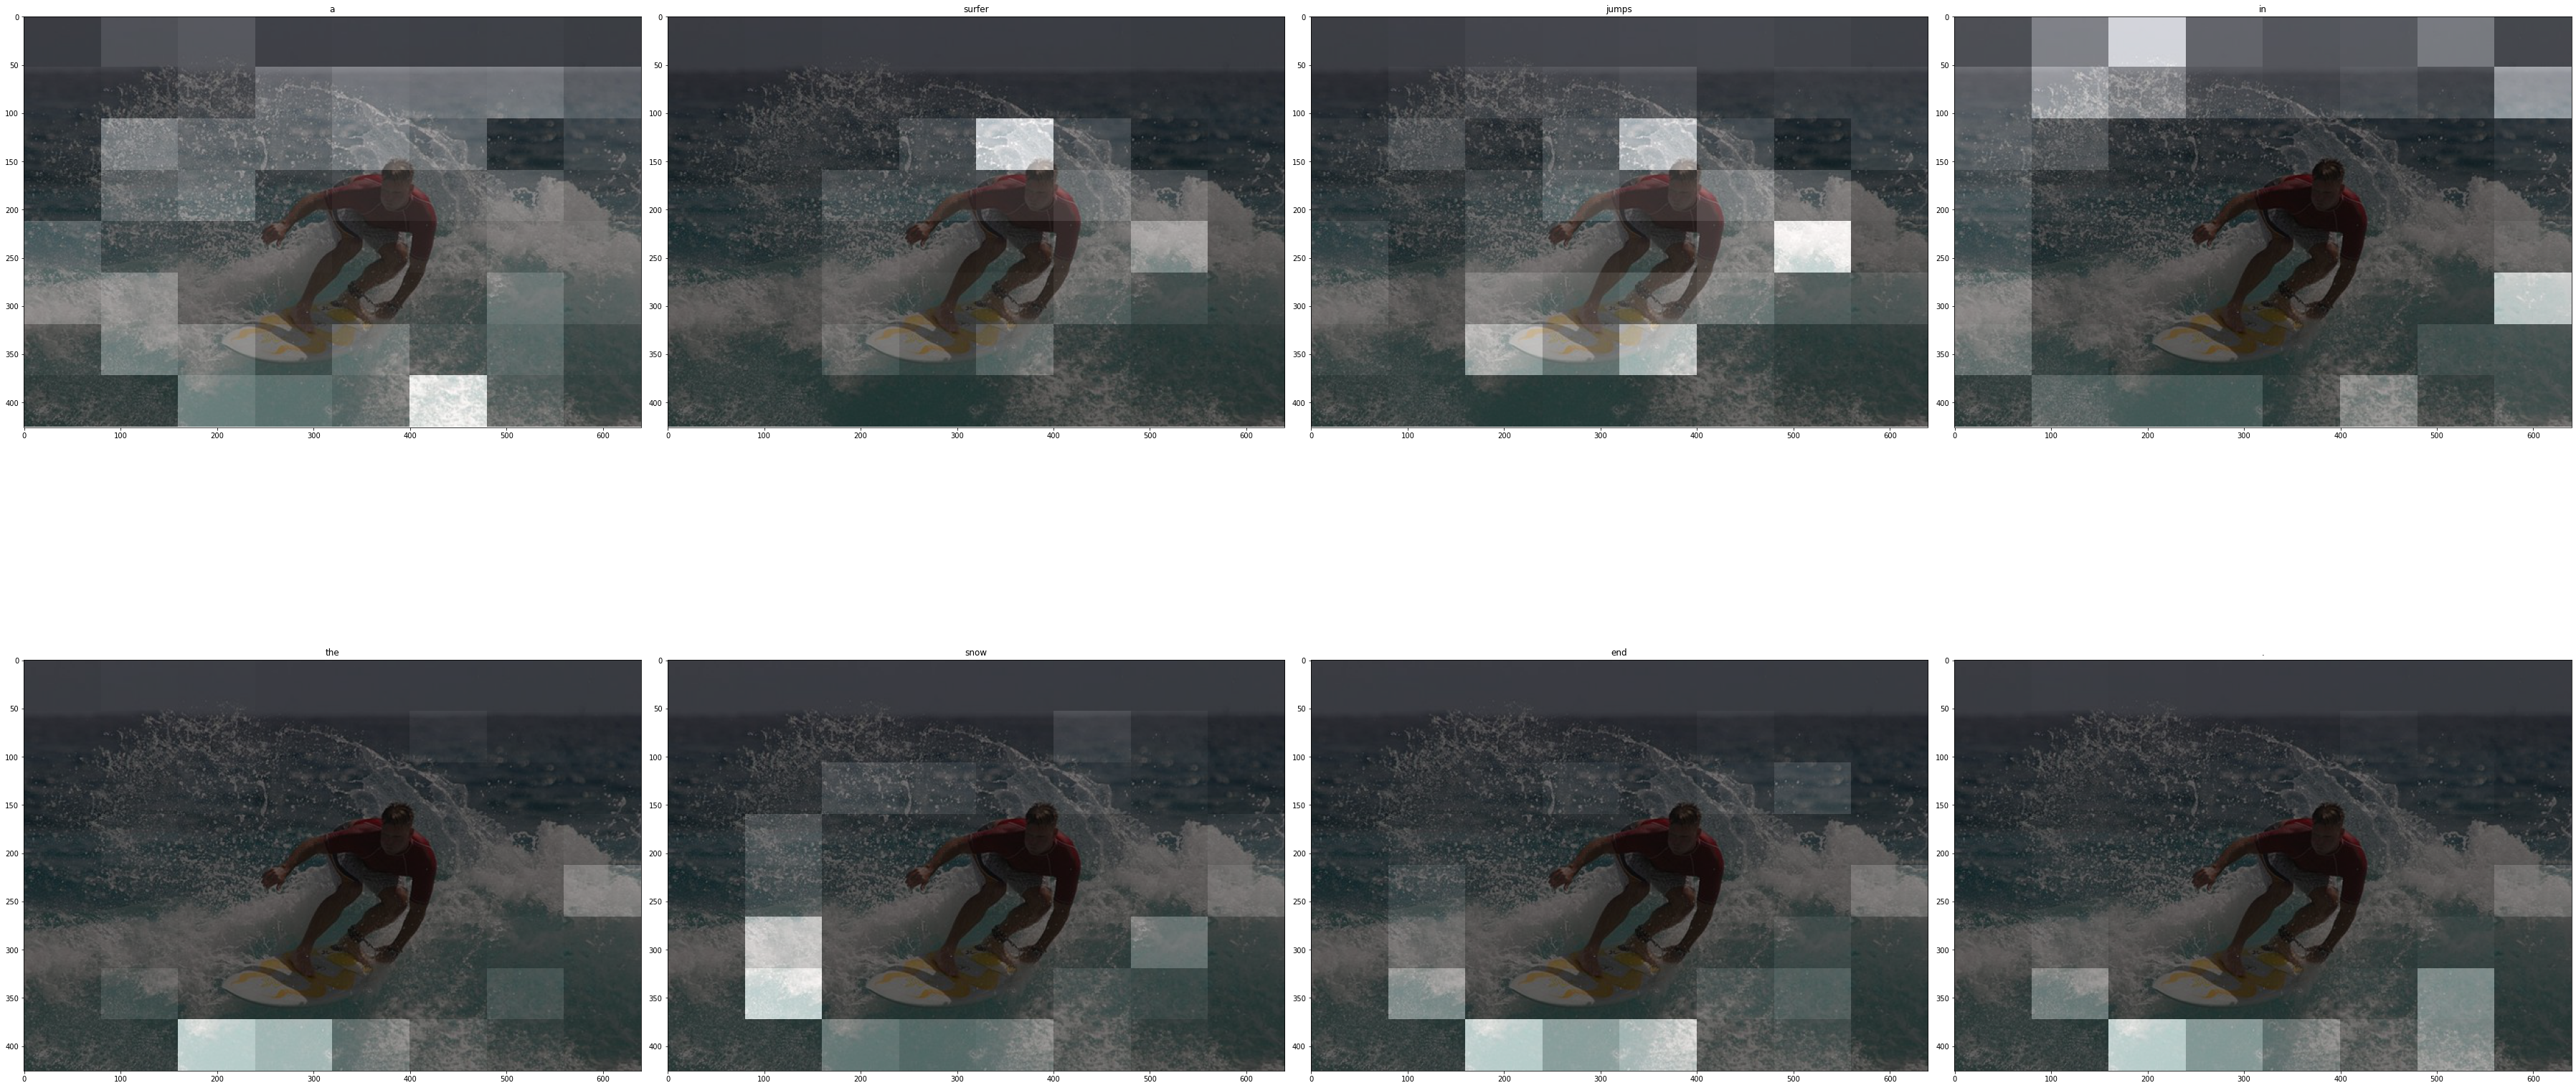

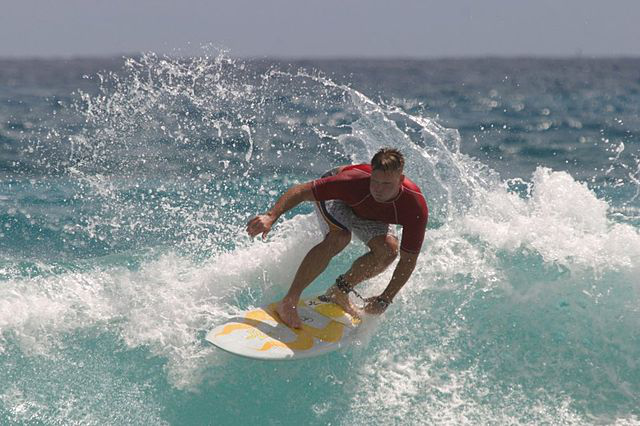

In [63]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

## Results

We obviously cannot cross-validate the parameters and architectures. We are training with a relatively small amount of epochs and estimating network performance based on loss and time required, while testing the quality of captioning with sentence_bleu for selected images and corpus_bleu for a smaller part of the validation set.

The encoder InceptionV3 with GRU and preprocessing + embeddings seemed to produce the optimal results concerning the corpus_bleu score, although with not significant difference compared to the Xception one.